Testing out stuff for "increasing the granularity" -- Time-domain L-by-L samples broadcasting in DANSE
--> See Word journal week25 2022, MON.

In [367]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

In [368]:
# Constants
N = 2**8       # FFT size (chunk length)
ovlp = .5       # frames overlap 
L = 10          # broadcast length
# L = int(N / 2)          # broadcast length
Mk = 1          # number of channels
SEED = 12345    # random generator seed
fs = 16000      # sampling frequency [Hz]
T = 4 * N / fs          # duration [s]

In [369]:
# Other constants (indirect)
Ns = int(N * (1 - ovlp))

In [370]:
# Random generator
rng = np.random.default_rng(SEED)

# Generate a chunk of (real - time-domain) multichannel signal
yk = 2 * rng.random((int(T * fs), Mk)) - 1

# Generate a set of (complex - freq.-domain) filters -- only positive frequencies (`int(N / 2 + 1)`)
# wkk = 2 * rng.random((int(N / 2 + 1), Mk)) - 1 + 1j * (2 * rng.random((int(N / 2 + 1), Mk)) - 1)
# Generate a set of (complex - freq.-domain) filters -- all frequencies
wkk_posf = 2 * rng.random((int(N / 2 + 1), Mk)) - 1 + 1j * (2 * rng.random((int(N / 2 + 1), Mk)) - 1)
# wkk_posf = np.zeros((int(N / 2 + 1), Mk))
# wkk_posf[:, 0] = 1
# Complete frequency spectrum (with negative frequencies)
wkk_posf[0, :] = wkk_posf[0, :].real      # Set DC to real value
wkk_posf[-1, :] = wkk_posf[-1, :].real    # Set Nyquist to real value
wkk = np.concatenate((wkk_posf, np.flip(wkk_posf[:-1, :].conj(), axis=0)[:-1, :]), axis=0)
# wkk = rng.random((int(N / 2 + 1), Mk))

# wkk = np.zeros((int(N / 2 + 1), Mk))
# wkk[:, 0] = 1
# wkk = np.ones((int(N / 2 + 1), Mk))
# wkk[20,:] = 3

# wkk = 2 * rng.random((N, Mk)) - 1
# wkk_hat = np.fft.fft(wkk, N, axis=0)
# wkk_hat = wkk_hat[:int(N /2 + 1), :]

In [371]:
# Process #1 - Freq. domain broadcasting
nChunks = int(T * fs // Ns)     # new chunk every `Ns` new samples

zkq_hat = np.zeros((N, nChunks), dtype=complex)
for l in range(nChunks):
    idxBeg = int(l * Ns)             # new chunk every `Ns` new samples
    idxEnd = int(idxBeg + N)
    if idxEnd > int(T * fs):
        break
    ykl = yk[idxBeg:idxEnd, :]  # current data chunk (multichannel)

    # Go to freq. domain
    ykl_hat = np.fft.fft(ykl, N, axis=0)

    # Apply compression
    zk_hat = np.einsum('ij,ij->i', wkk.conj(), ykl_hat)

    # Broadcast
    zkq_hat[:, l] = zk_hat

# get back to time-domain
zkq = np.fft.ifft(zkq_hat, N, axis=0)
zkq = np.real_if_close(zkq)

# Reconstruct whole zq time-domain
zkq_whole = np.zeros(int(T * fs))
for l in range(zkq.shape[-1]):
    idxBeg = int(l * Ns)             # new chunk every `Ns` new samples
    idxEnd = int(idxBeg + N)
    if idxEnd > len(zkq_whole):
        break
    zkq_whole[idxEnd-Ns:idxEnd] = zkq[Ns:, l]  # TODO: <-- that doesnt really make sense, to add up overlapping segment (zkq was not built from OLS/OLA)

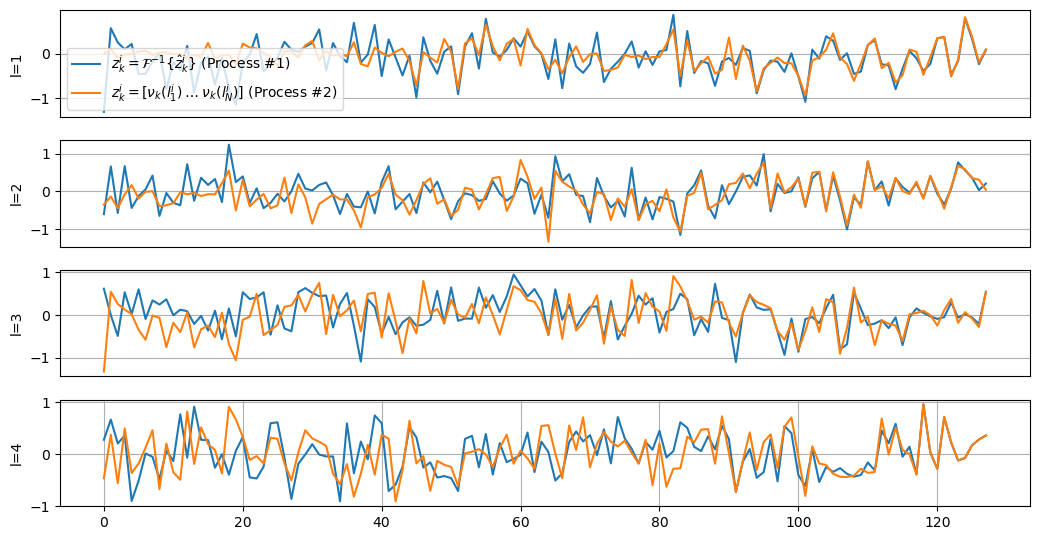

In [372]:
# OLS
# -- as straight forward as it gets
import scipy.signal as sig
\
# New samples per chunk: `L`

nChunks = int(T * fs // L)

filtered = np.zeros(int(T * fs))
for l in range(nChunks):

    idxEnd = int((l + 1) * L)
    idxBeg = int(idxEnd - N)
    # idxBeg = int(idxEnd - L)
    # ykl = yk[idxBeg:idxEnd, :]
    # ykl = np.concatenate((np.zeros((N - L, Mk)), yk[idxBeg:idxEnd, :]))
    if idxBeg < 0:
        ykl = np.concatenate((np.zeros((N - idxEnd, Mk)), yk[0:idxEnd, :]))
    else:
        ykl = yk[idxBeg:idxEnd, :]

    # FFT
    ykl_hat = np.fft.fft(ykl, N, axis=0)

    # Apply compression
    zk_hat = np.einsum('ij,ij->i', wkk.conj(), ykl_hat)
    # Go back to time domain
    zkl = np.fft.ifft(zk_hat, N, axis=0)
    zkl = np.real_if_close(zkl)
    zkl = np.squeeze(zkl)

    filtered[idxEnd-L:idxEnd] = zkl[-L:]


# Re-divide into (DANSE update) chunks
nChunksNs = int(T * fs // Ns)
zkq_hat_v2 = np.zeros((N, nChunksNs), dtype=complex)
zkq_v2 = np.zeros((N, nChunksNs))
for l in range(nChunksNs):
    idxBeg = int(l * Ns)             # new chunk every `Ns` new samples
    idxEnd = int(idxBeg + N)
    if idxEnd > len(filtered):
        break
    zkq_v2[:, l] = filtered[idxBeg:idxEnd]
    zkq_hat_v2[:, l] = np.fft.fft(zkq_v2[:, l], N, axis=0)


# Comparing z_k from node q's perspective using process #1 and #2
plottype = 'perchunk'
# plottype = 'whole'
if plottype == 'perchunk':
    nsp = np.amin([zkq_hat_v2.shape[-1], 4])    # num. of subplots
    fig, axes = plt.subplots(nsp, 1)
    for ii in range(nsp):
        axes[ii].plot(zkq[:, ii], label='$z_k^i = \\mathcal{{F}}^{{-1}}\\{\\hat{{z}}_k^i\\}$ (Process #1)')
        axes[ii].plot(zkq_v2[:, ii], label='$z_k^i = [\\nu_k(l_1^i) \\:\\dots\\: \\nu_k(l_N^i)]$ (Process #2)')#, '--')
        axes[ii].grid()
        axes[ii].set_ylabel(f'l={ii+1}')
        if ii == 0:
            axes[ii].legend()
        if ii < nsp - 1:
            axes[ii].set_xticks([])
elif plottype == 'whole':
    fig, axes = plt.subplots(1, 1)
    axes.plot(zkq_whole)
    axes.plot(filtered)#, '--')
    axes.vlines(np.arange(nChunksNs) * Ns, ymin=-1, ymax=1, color='k')
fig.set_size_inches(10.5, 5.5)
plt.tight_layout()
plt.show()

# # Comparing \hat{z}_k from node q's perspective using process #1 and #2
# fig, axes = plt.subplots(zkq_hat_v2.shape[-1], 2)
# fig.set_size_inches(10.5, 5.5)
# axes[0, 0].set_title(f'Real part differences')
# axes[0, 1].set_title(f'Imag part differences')
# for ii in range(zkq_hat_v2.shape[-1]):
#     axes[ii, 0].plot(np.real(zkq_hat[:, ii]) - np.real(zkq_hat_v2[:, ii]))
#     axes[ii, 0].grid()
#     axes[ii, 0].set_ylabel(f'l={ii+1}')
#     axes[ii, 1].plot(np.imag(zkq_hat[:, ii]) - np.imag(zkq_hat_v2[:, ii]))
#     axes[ii, 1].grid()
#     if ii < zkq_hat_v2.shape[-1] - 1:
#         axes[ii, 0].set_xticks([])
#         axes[ii, 1].set_xticks([])
# plt.tight_layout()
# plt.show()

In [373]:

def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

In [374]:
n * (1 - ovlp)

100.0

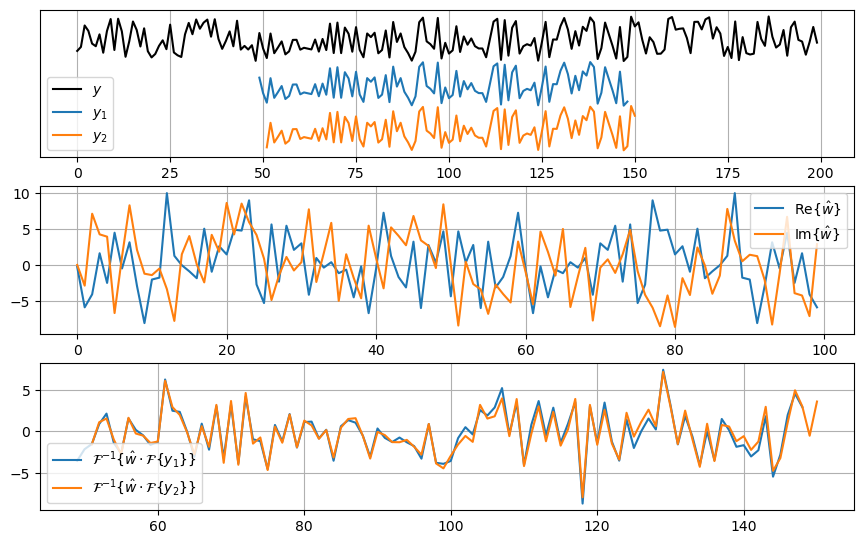

In [375]:
import soundfile as sf


n = 200
M = 100
rng = np.random.default_rng(SEED)
y = 2 * rng.random(n) - 1
# 2 overlapping chunks
ovlpeff = 98  # overlap between chunks (%)

ovlp = .5 + ovlpeff / 100 * .25

# ovlp = .75
y1 = y[(int(ovlp * n)-M):int(ovlp * n)]
y2 = y[int(n * (1 - ovlp)):(int(n * (1 - ovlp))+M)]

filtertype = 'random'
# filtertype = 'rir'
filteringdomain = 't'   # convolution
# filteringdomain = 'f'   # multiplication

N = len(y1)
if filtertype == 'random':
    w = 2 * rng.random(N) - 1
    # w = np.zeros(N)
    # w[0] = 1
elif filtertype == 'rir':
    path = 'U:/py/sounds-phd/97_tests/05_dsp_related/00_signals/rir1.wav'
    w, fs = sf.read(path)
    w = w[:N]


# nfft = 2*N - 1
nfft = N

w_hat = np.fft.fft(w, nfft, axis=0)


if filteringdomain == 'f':

    y1_hat = np.fft.fft(y1, nfft, axis=0)
    y2_hat = np.fft.fft(y2, nfft, axis=0)
    z1_hat = y1_hat * w_hat
    z2_hat = y2_hat * w_hat

    y1_back = np.fft.ifft(z1_hat, nfft, axis=0)
    y1_back = np.real_if_close(y1_back)
    y2_back = np.fft.ifft(z2_hat, nfft, axis=0)
    y2_back = np.real_if_close(y2_back)

    # y1_back = _centered(y1_back, N)
    # y2_back = _centered(y2_back, N)
elif filteringdomain == 't':
    # y1_back = np.convolve(w, y1, mode='same')
    # y2_back = np.convolve(w, y2, mode='same')
    y1_back = sig.convolve(w, y1, mode='same', method='direct')
    y2_back = sig.convolve(w, y2, mode='same', method='direct')

fig, axes = plt.subplots(3,1)
fig.set_size_inches(10.5, 6.5)
axes[0].plot(y, 'k', label='$y$')
axes[0].plot(np.arange(start=int(ovlp * n)-M, stop=int(ovlp * n)), y1 - 2, 'C0', label='$y_1$')
axes[0].plot(np.arange(start=n * (1 - ovlp), stop=n * (1 - ovlp)+M), y2 - 4, 'C1', label='$y_2$')
axes[0].grid()
axes[0].legend()
axes[0].set_yticks([])
axes[1].plot(np.real(w_hat), label='Re{$\\hat{{w}}$}')
axes[1].plot(np.imag(w_hat), label='Im{$\\hat{{w}}$}')
axes[1].grid()
axes[1].legend()
axes[2].plot(np.arange(start=int(ovlp * n)-M, stop=int(ovlp * n)), y1_back, label='$\\mathcal{{F}}^{{-1}}\\{\\hat{{w}}\\cdot\\mathcal{{F}}\\{y_1\\}\\}$')
axes[2].plot(np.arange(start=n * (1 - ovlp), stop=n * (1 - ovlp)+M), y2_back, label='$\\mathcal{{F}}^{{-1}}\\{\\hat{{w}}\\cdot\\mathcal{{F}}\\{y_2\\}\\}$')
axes[2].grid()
axes[2].legend()



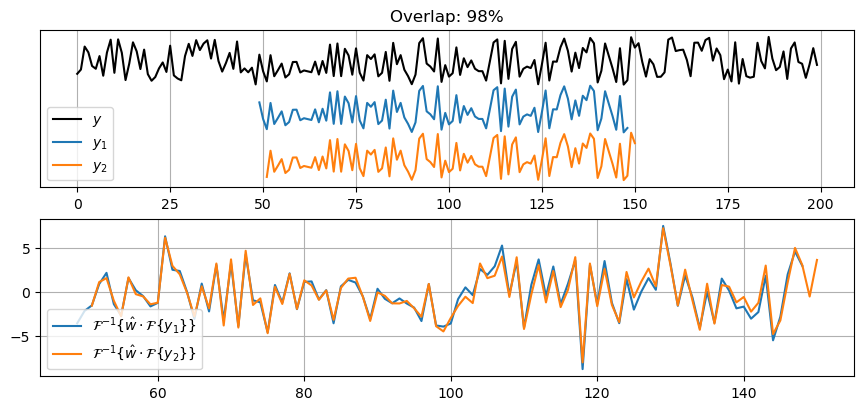

In [376]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(10.5, 4.5)
axes[0].plot(y, 'k', label='$y$')
axes[0].plot(np.arange(start=int(ovlp * n)-M, stop=int(ovlp * n)), y1 - 2, 'C0', label='$y_1$')
axes[0].plot(np.arange(start=n * (1 - ovlp), stop=n * (1 - ovlp)+M), y2 - 4, 'C1', label='$y_2$')
axes[0].grid()
axes[0].legend()
axes[0].set_yticks([])
axes[0].set_title(f'Overlap: {round(ovlpeff, 1)}%')
axes[1].plot(np.arange(start=int(ovlp * n)-M, stop=int(ovlp * n)), y1_back, label='$\\mathcal{{F}}^{{-1}}\\{\\hat{{w}}\\cdot\\mathcal{{F}}\\{y_1\\}\\}$')
axes[1].plot(np.arange(start=n * (1 - ovlp), stop=n * (1 - ovlp)+M), y2_back, label='$\\mathcal{{F}}^{{-1}}\\{\\hat{{w}}\\cdot\\mathcal{{F}}\\{y_2\\}\\}$')
axes[1].grid()
axes[1].legend()



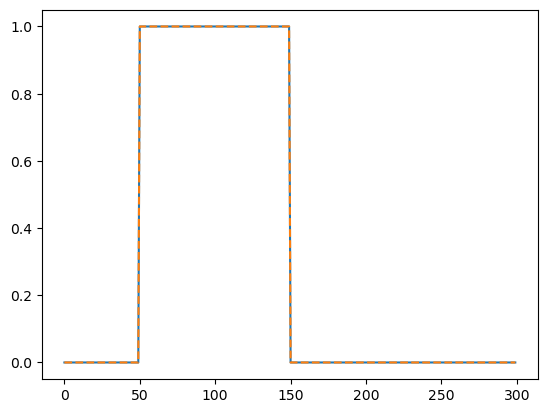

In [377]:

nfft = 300

y = np.concatenate((np.zeros(50), np.ones(100), np.zeros(150)))

w = 2 * rng.random(nfft) - 1



w_hat = np.fft.fft(w, nfft, axis=0)

y_hat = np.fft.fft(y, nfft, axis=0)
# z_hat = y_hat * w_hat
z_hat = y_hat

y_back = np.fft.ifft(z_hat, nfft, axis=0)
y_back = np.real_if_close(y_back)

plt.plot(y)
plt.plot(y_back, '--')

